# Inflation Curves - Seasonality Adjustment

This notebook demonstrates how to access and use the functionalities of **Seasonality Adjustement of Inflation Curves** within the **LSEG Financial Analytics SDK**. 

Inflation curves provide forward Consumer Price Index data used for pricing inflation indexed instruments.

**You will be able to:**
- Configure seasonality adjustment for inflation curve data 
- Access to seasonality factors of inflation curve
- Override seasonality factors of inflation curve

## Imports

Import the following necessary modules:

- `lseg_analytics.market_data.inflation_curves` - To access inflation curves data

In [1]:
from lseg_analytics.market_data import inflation_curves as infc

import datetime as dt
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## 1. Deseasonlized Inflation Curve

We first build an inflation curve without seasonality. It is built according to the 3-step logic definition/parameters/request where **seasonality is set to `False` in parameters**. The results show in a dataframe and in a plot the deseasonlized inflation curve.

### Data Preparation

In [2]:
print("Step 1: Creating Curve Definition...")
# Select an Inflation Index
inflation_index = 'AGBRPI'

# Create curve definition object
curve_definition = infc.InflationCurveDefinitionItem(
        inflation_index = infc.InflationIndex(code=inflation_index) 
        )
print(f"   ✓ Instrument: {curve_definition.inflation_index}")

print("Step 2: Configuring Curve Parameters...")
# Create curve parameters object - optional
curve_parameters = infc.InflationCurveParameters(
        valuation_date_time = dt.datetime.strptime("2025-01-18", "%Y-%m-%d"),
        seasonality= infc.InflationSeasonality(apply_seasonality=False)  # Parameter to not use seasonal factors
    )
print(f"   ✓ Curve Parameters: {curve_parameters}")


print("Step 3: Create request item...")
# Create the main request object with basic configuration
request_item = infc.InflationCurvesRequestItem(
        curve_tag = f"{inflation_index}_InflationCurve",
        curve_definition = curve_definition,
        curve_parameters = curve_parameters,
    )
print(f"   ✓ Request Item: {json.dumps(request_item.as_dict(), indent=4)}")

Step 1: Creating Curve Definition...
   ✓ Instrument: {'code': 'AGBRPI'}
Step 2: Configuring Curve Parameters...
   ✓ Curve Parameters: {'valuationDateTime': '2025-01-18T00:00:00Z', 'seasonality': {'applySeasonality': False}}
Step 3: Create request item...
   ✓ Request Item: {
    "curveTag": "AGBRPI_InflationCurve",
    "curveDefinition": {
        "inflationIndex": {
            "code": "AGBRPI"
        }
    },
    "curveParameters": {
        "valuationDateTime": "2025-01-18T00:00:00Z",
        "seasonality": {
            "applySeasonality": false
        }
    }
}


### Request Execution

In [3]:
# Execute the calculation using the calculate function
# The 'universe' parameter accepts a list of request items for batch processing
response = infc.calculate(universe=[request_item])
curve_data = response['data'][0]

### Results Display

In [4]:
cpis = curve_data['curves']['consumerPriceIndexCurvePoints']
cpis_df = pd.DataFrame(cpis)
cpis_df["Month/Year"] = cpis_df['month'] + ' ' + cpis_df['year'].astype(str)
del cpis_df['month'],cpis_df['year']
cpis_df.set_index("Month/Year", inplace = True)
cpis_df.head(5) # remove .head(5) to get the entire dataframe

indexValue
Month/Year               
November 2024  390.900000
December 2024  392.100000
January 2025   393.604828
February 2025  395.115431
March 2025     396.631832

Text(0, 0.5, 'CPI Value')

<Figure size 640x480 with 0 Axes>

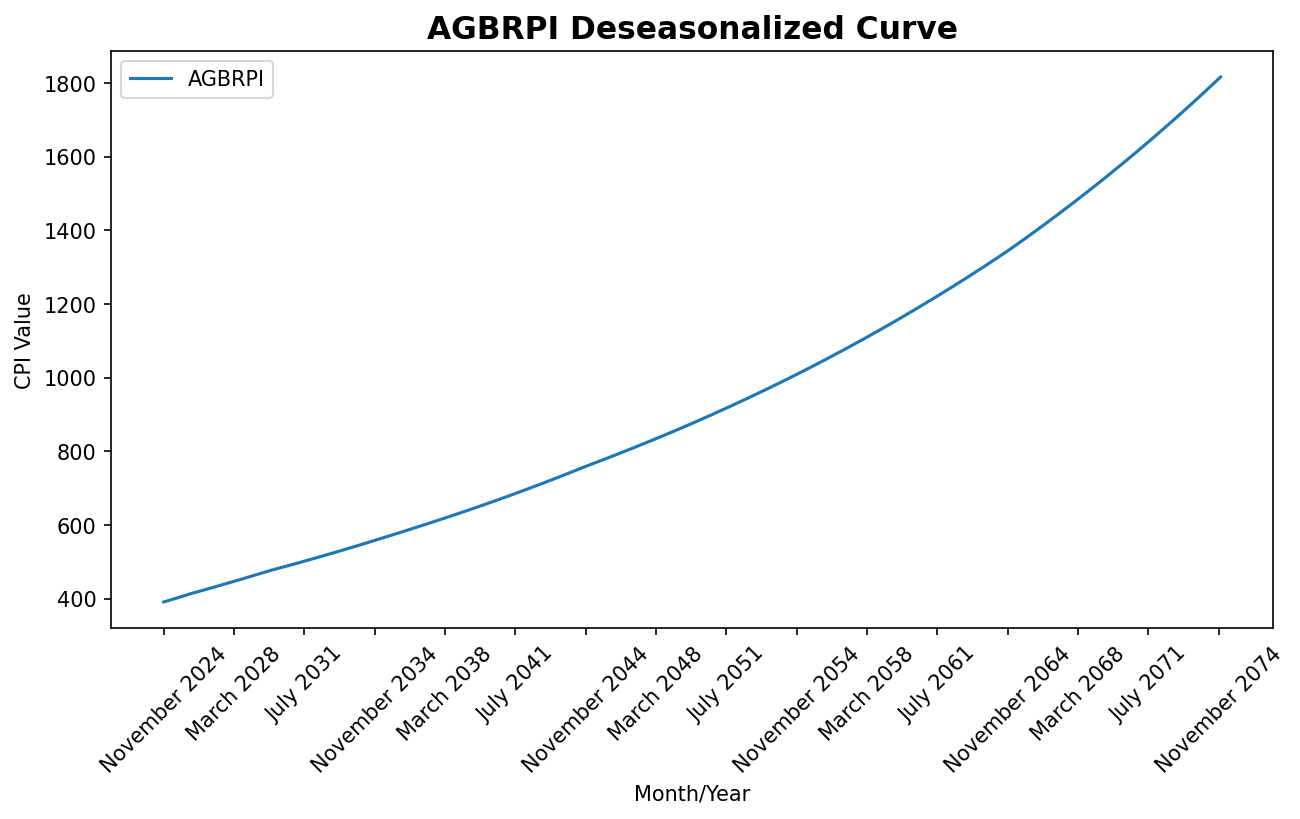

In [5]:
plt.figure()
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(cpis_df.index, cpis_df['indexValue'], label = inflation_index)
plt.title(f"{inflation_index} Deseasonalized Curve", fontdict={'fontweight':'bold','fontsize':15})
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.xlabel('Month/Year')
plt.ylabel('CPI Value')

## 2. Seasonalized Inflation Curve

Starting from the previous inflation curve request, we build the seasonalised inflation curve by simply **setting seasonality to `True` in parameters**. The results show in a dataframe and in a plot the seasonlized inflation curve and the access to seasonality factors

### Data Preparation

In [6]:
# This time we set apply_seasonality to True 
curve_parameters.seasonality = infc.InflationSeasonality(apply_seasonality=True)

### Request Execution

In [7]:
# Execute the calculation using the calculate function
# The 'universe' parameter accepts a list of request items for batch processing
response = infc.calculate(universe=[request_item])
curve_data = response['data'][0]

### Results Display

In [8]:
cpis = curve_data['curves']['consumerPriceIndexCurvePoints']
cpis_df = pd.DataFrame(cpis)
cpis_df["Month/Year"] = cpis_df['month'] + ' ' + cpis_df['year'].astype(str)
del cpis_df['month'],cpis_df['year']
cpis_df.set_index("Month/Year", inplace = True)
cpis_df.head(5)

indexValue
Month/Year               
November 2024  390.900000
December 2024  392.100000
January 2025   391.652621
February 2025  394.156422
March 2025     396.006201

Text(0, 0.5, 'CPI Value')

<Figure size 640x480 with 0 Axes>

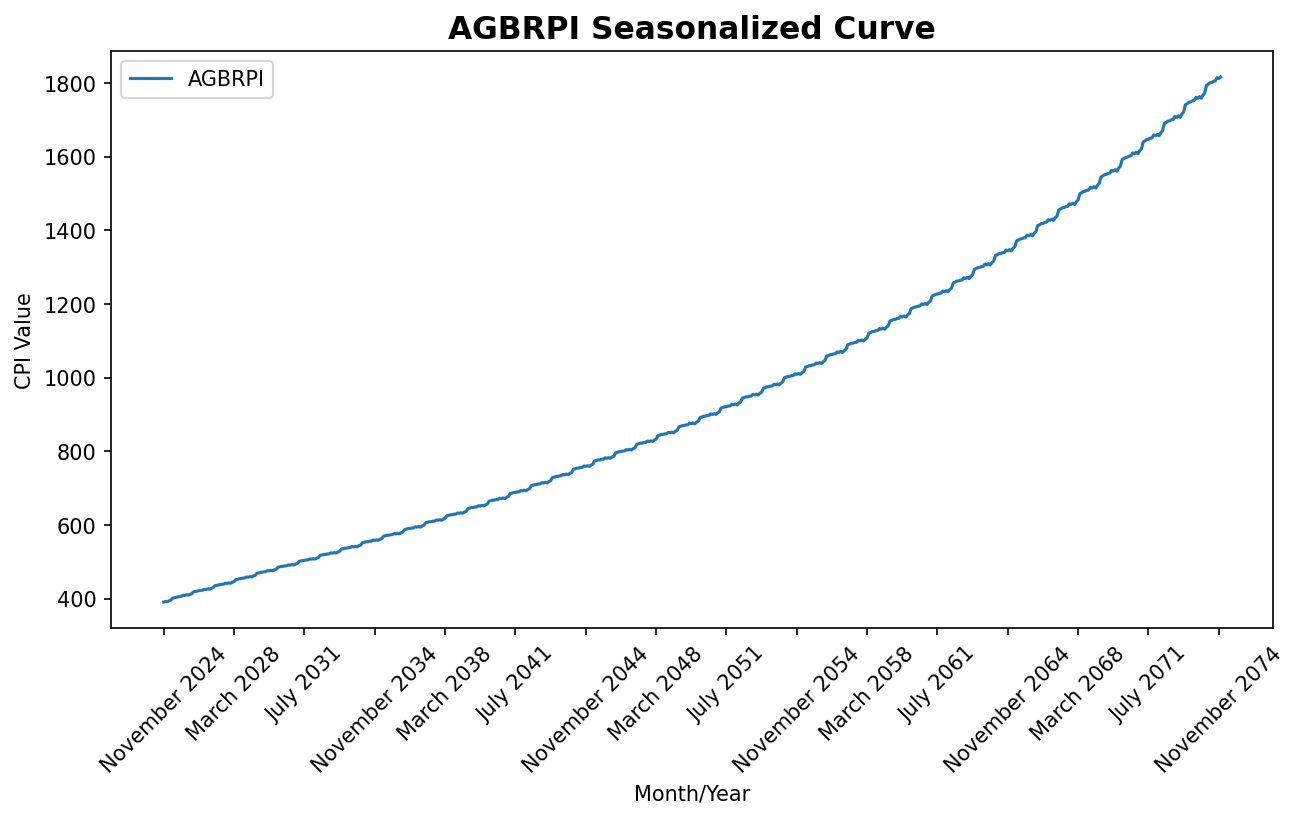

In [9]:
plt.figure()
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(cpis_df.index, cpis_df['indexValue'], label = inflation_index)
plt.title(f"{inflation_index} Seasonalized Curve", fontdict={'fontweight':'bold','fontsize':15})
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.xlabel('Month/Year')
plt.ylabel('CPI Value')

In [10]:
# seasonality factors
pd.DataFrame(curve_data['curves']['seasonalityCurvePoints'])

factor      month
0   0.993016    January
1   0.995548   February
2   0.996401      March
3   1.005340      April
4   1.004464        May
5   1.004223       June
6   1.002202       July
7   1.001522     August
8   0.999463  September
9   1.001850    October
10  0.998009   November
11  0.997962   December

## 3. Seasonality Factors Override

From the previous curve, we build below a last curve by **overriding seasonality factors in parameters**. The result shows the seasonality factors and in particular the overridden ones

### Data Preparation

In [11]:
# Override some of factors with user defined ones
seasonality_factor_june = infc.InflationSeasonalityItem(factor=1, month=infc.MonthEnum.JUNE) # Create factor for June
seasonality_factor_july = infc.InflationSeasonalityItem(factor=1, month=infc.MonthEnum.JULY) # Create factor for July
seasonality_factor_august = infc.InflationSeasonalityItem(factor=1, month=infc.MonthEnum.AUGUST) # Create factor for August

curve_parameters.seasonality = infc.InflationSeasonality(
    apply_seasonality=True,
    seasonalities = [seasonality_factor_june, seasonality_factor_july, seasonality_factor_august]
    )


### Request Execution

In [12]:
# Execute the calculation using the calculate function
# The 'universe' parameter accepts a list of request items for batch processing
response = infc.calculate(universe=[request_item])
curve_data = response['data'][0]

### Results Display

In [13]:
cpis = curve_data['curves']['consumerPriceIndexCurvePoints']
pd.DataFrame(curve_data['curves']['seasonalityCurvePoints'])

factor isOverridden      month
0   0.993016          NaN    January
1   0.995548          NaN   February
2   0.996401          NaN      March
3   1.005340          NaN      April
4   1.004464          NaN        May
5   1.000000         True       June
6   1.000000         True       July
7   1.000000         True     August
8   0.999463          NaN  September
9   1.001850          NaN    October
10  0.998009          NaN   November
11  0.997962          NaN   December